In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

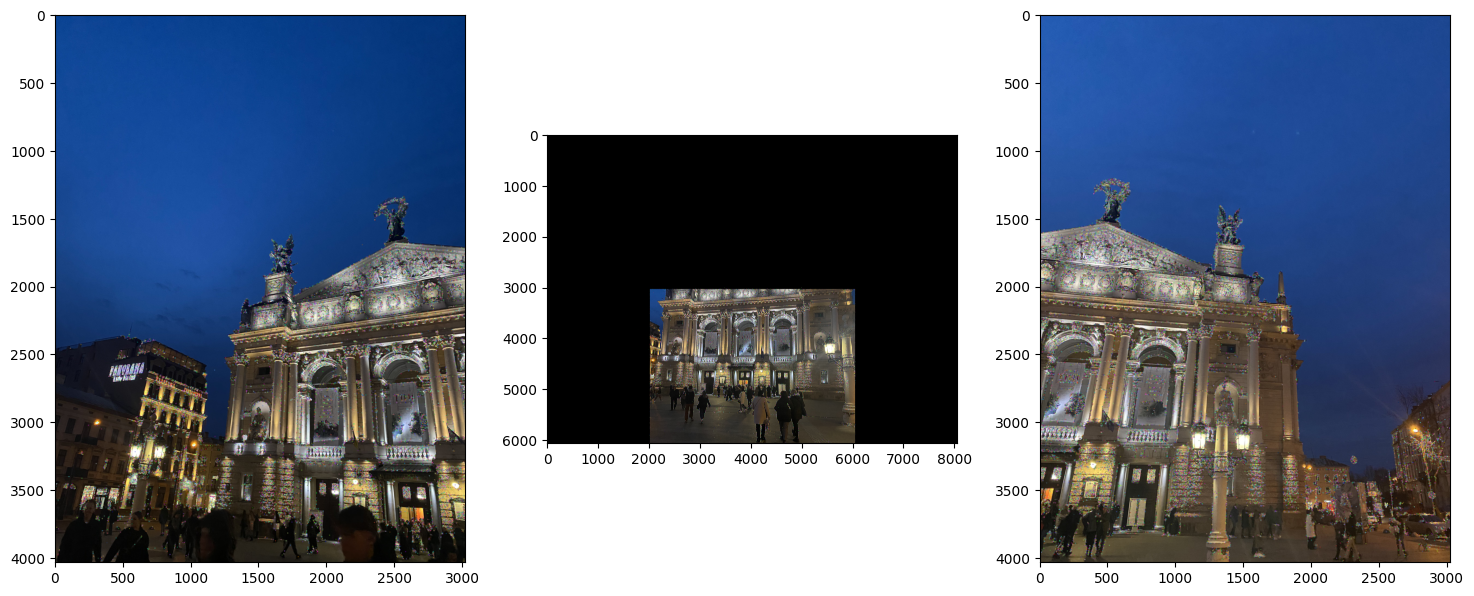

In [4]:
image_left = cv2.imread('images/left.jpg')
image_center = cv2.imread('images/center.jpg')
image_right = cv2.imread('images/right.jpg')

image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)
image_center = cv2.cvtColor(image_center, cv2.COLOR_BGR2RGB)
image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB)

# extend central image
h_orig, w_orig = image_center.shape[:2]
scaled_image = np.zeros((2*h_orig, 2*w_orig, 3), dtype=np.uint8)
scaled_image[h_orig:2*h_orig, w_orig//2:w_orig//2+w_orig] = image_center
image_center = scaled_image

img1 = cv2.cvtColor(image_left, cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(image_center, cv2.COLOR_RGB2GRAY)
img3 = cv2.cvtColor(image_right, cv2.COLOR_RGB2GRAY)

# Initialize the SIFT feature detector 
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors 
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
keypoints3, descriptors3 = sift.detectAndCompute(img3, None)

# Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(image_left, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(image_center, keypoints2, None)
image3_keypoints = cv2.drawKeypoints(image_right, keypoints3, None)

# Display images with keypoints
f, axarr = plt.subplots(1, 3, figsize=(18,14))
axarr[0].imshow(image1_keypoints)
axarr[1].imshow(image2_keypoints)
axarr[2].imshow(image3_keypoints)

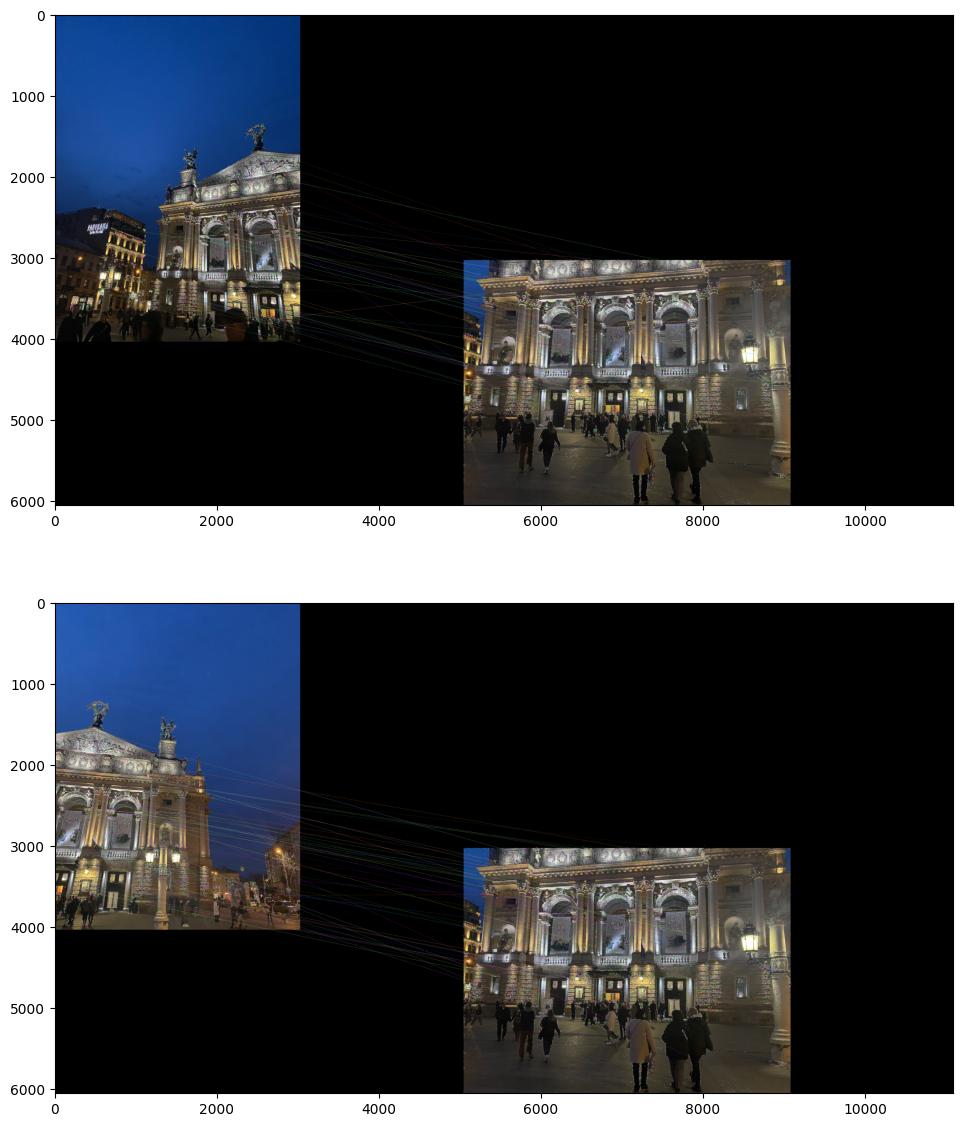

In [5]:
# Initialize the feature matcher using brute-force matching
matcher = cv2.BFMatcher()

# Match the descriptors using brute-force matching
matches1 = matcher.match(descriptors1, descriptors2)
matches2 = matcher.match(descriptors3, descriptors2)

# Select the top N matches
num_matches = 50
matches1 = sorted(matches1, key=lambda x: x.distance)[:num_matches]
matches2 = sorted(matches2, key=lambda x: x.distance)[:num_matches]

image_matches1 = cv2.drawMatches(image_left,  keypoints1, image_center, keypoints2, matches1, None)
image_matches2 = cv2.drawMatches(image_right, keypoints3, image_center, keypoints2, matches2, None)

f, axarr = plt.subplots(2, 1, figsize=(18,14))
axarr[0].imshow(image_matches1)
axarr[1].imshow(image_matches2)

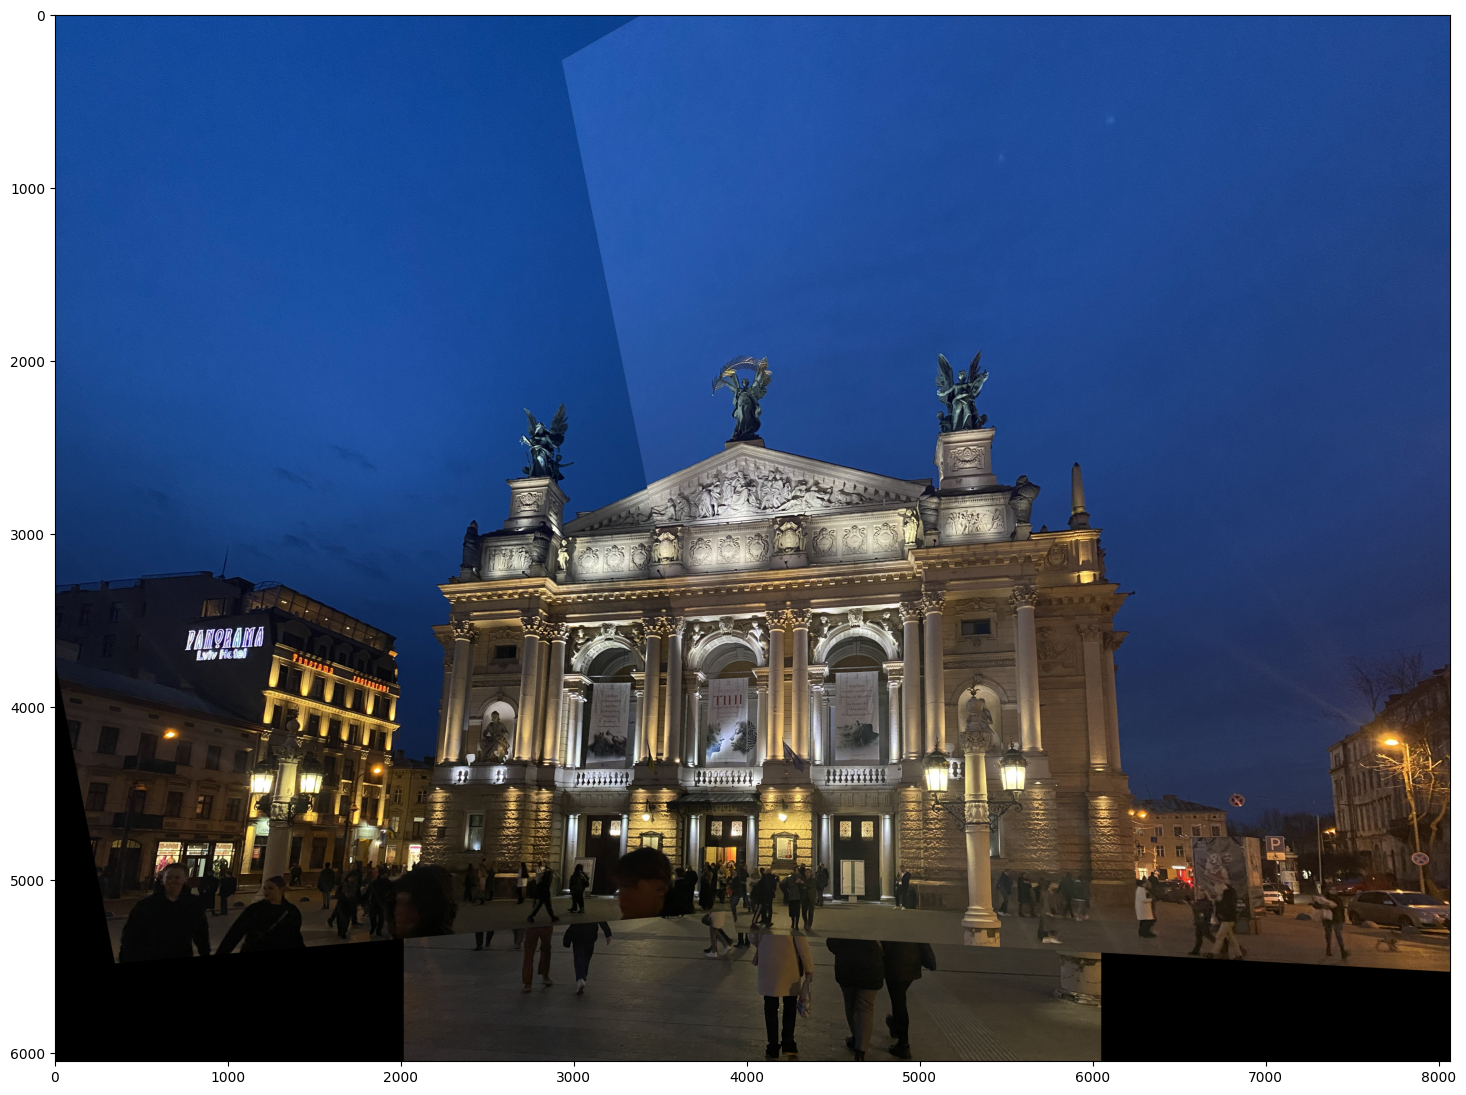

In [6]:
src_left  = np.float32([keypoints1[m.queryIdx].pt for m in matches1]).reshape(-1,1,2)
dst_left  = np.float32([keypoints2[m.trainIdx].pt for m in matches1]).reshape(-1,1,2)
src_right = np.float32([keypoints3[m.queryIdx].pt for m in matches2]).reshape(-1,1,2)
dst_right = np.float32([keypoints2[m.trainIdx].pt for m in matches2]).reshape(-1,1,2)

# find homographies with RANSAC
homography_left, _  = cv2.findHomography(src_left,  dst_left, cv2.RANSAC, 5.0)
homography_right, _ = cv2.findHomography(src_right, dst_right, cv2.RANSAC, 5.0)

# warp images
result = image_center.copy()
height, width = result.shape[:2]
warped_left  = cv2.warpPerspective(image_left,  homography_left,  (width, height))
warped_right = cv2.warpPerspective(image_right, homography_right, (width, height))

# throw left image
gray_warped_left  = cv2.cvtColor(warped_left,  cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray_warped_left, 0, 1, cv2.THRESH_BINARY)
result[np.where(mask == 1)] = warped_left[np.where(mask == 1)]

# throw right image
gray_warped_right = cv2.cvtColor(warped_right, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray_warped_right, 0, 1, cv2.THRESH_BINARY)
result[np.where(mask == 1)] = warped_right[np.where(mask == 1)]

plt.figure(figsize=(18,14))
plt.imshow(result, cmap='gray')

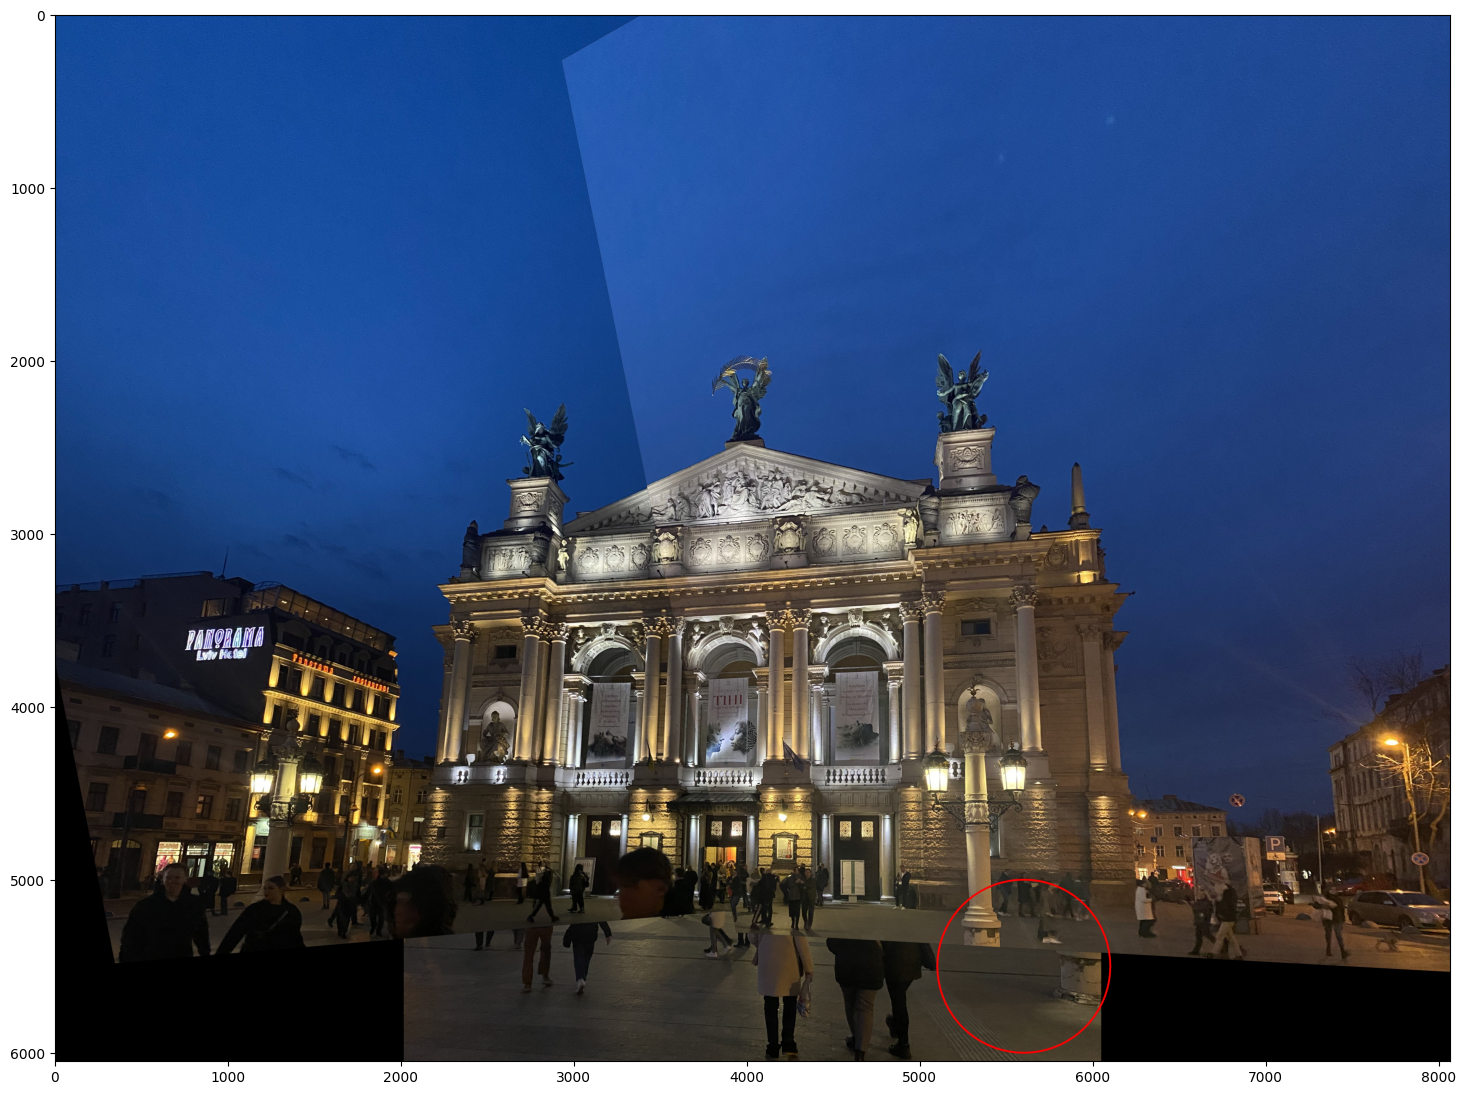

In [7]:
# show defect
plt.figure(figsize=(18,14))
cv2.circle(result, (5600, 5500), 500, ((255, 0, 0)), 10)
plt.imshow(result)